#### Results for poster at HEAD21

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
def_last_prob_df = pd.read_csv('out_data/last_new.csv')
complement_df = pd.read_csv('out_data/complement_after.csv')
def_first_prob_df = pd.read_csv('out_data/most_probable_new.csv')

/tmp/ipykernel_103704/3125906549.py:2: DtypeWarning: Columns (4,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  complement_df = pd.read_csv('out_data/complement_after.csv')


In [3]:
def_first_prob_df_filtered = def_first_prob_df.dropna(subset=["name"])
# extract unique chandra_source_id values from def_first_prob_df
chandra_ids_in_first = def_first_prob_df_filtered['chandra_source_id'].unique()

# filter def_last_prob_df based on the extracted chandra_source_id values
filtered_last_prob_df = def_last_prob_df[def_last_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]
filtered_complement_df = complement_df[complement_df['chandra_source_id'].isin(chandra_ids_in_first)]

In [4]:
df_pos = def_first_prob_df_filtered.query('nway_separation <= 0.8 and min_theta_mean <= 5 and parallax == parallax and parallax >= 0')
df_pos.dropna(subset='name', inplace=True)
chandra_ids_in_pos = df_pos['chandra_source_id'].unique()

df_neg= filtered_last_prob_df[filtered_last_prob_df['chandra_source_id'].isin(chandra_ids_in_pos)]

df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
df_pos['gmag_logflux'] = df_pos['phot_g_mean_mag'] + np.log10(df_pos['flux_aper_b']/1e-13)*2.5
df_neg['gmag_logflux'] = df_neg['phot_g_mean_mag'] + np.log10(df_neg['flux_aper_b']/1e-13)*2.5

/tmp/ipykernel_103704/1374581884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos.dropna(subset='name', inplace=True)
/tmp/ipykernel_103704/1374581884.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_103704/1374581884.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_103704/137458188

In [5]:
df_comp= filtered_complement_df[filtered_complement_df['chandra_source_id'].isin(chandra_ids_in_pos)]

df_comp['flux_aper_b'].replace(0, np.nan, inplace=True)
df_comp['gmag_logflux'] = df_comp['phot_g_mean_mag'] + np.log10(df_comp['flux_aper_b']/1e-13)*2.5

/tmp/ipykernel_103704/2450971775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp['flux_aper_b'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_103704/2450971775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp['gmag_logflux'] = df_comp['phot_g_mean_mag'] + np.log10(df_comp['flux_aper_b']/1e-13)*2.5


In [6]:
df_all = pd.concat([df_pos, df_neg], ignore_index=True)

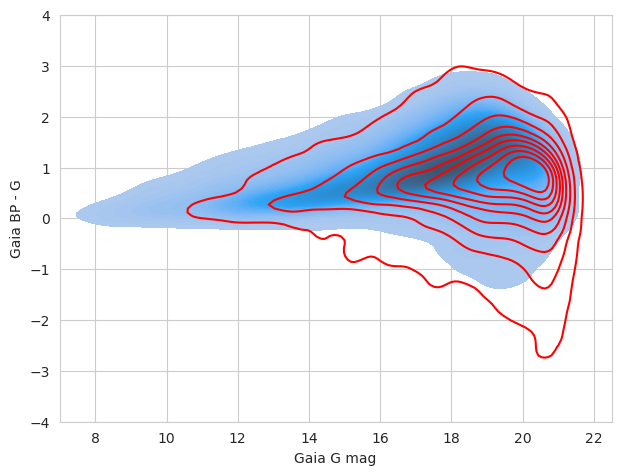

In [25]:
# set the aesthetic style of the plots
sns.set_style("whitegrid")

# create a figure and a grid of subplots
fig, ax = plt.subplots()

# plot the density plots for positive and negative points on the same axes
sns.kdeplot(data=df_pos, x='phot_g_mean_mag', y='bp_g', fill=True, levels=50, ax=ax, label='Positive')
sns.kdeplot(data=df_comp, x='phot_g_mean_mag', y='bp_g', fill=False, color='red', levels=10, ax=ax, label='Negative')
ax.set_xlabel('Gaia G mag')  # x-axis label
ax.set_ylabel('Gaia BP - G')  # y-axis label
plt.tight_layout()
ax.set_ylim([-4,4])
ax.set_xlim([7,22.5])
plt.savefig('figures/posterhead21/Gaia_densities.png',dpi=300)

---
#### Preprocessing

In [7]:
feature_names = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'flux_aper_b',
    'gmag_logflux'
]

# List of features to skip for the log transformation
skip_log_features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'gmag_logflux'
]

In [12]:
from utils import preprocess, handle_missing_values, standardize
# Preprocess the data
X, Y = preprocess(df_pos, df_neg, feature_names, skip_log_features)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, shuffle=True, random_state=0)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
X_train, X_test, scaler = standardize(X_train, X_test)

/mnt/d/workspace/starsml_head21/utils.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [13]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {0.0: 0.4993269701419481, 1.0: 0.5006730298580518}
Test proportions: {0.0: 0.501570306923626, 1.0: 0.498429693076374}


In [14]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature phot_g_mean_mag: 0.51%
Percentage of NaN values in feature phot_bp_mean_mag: 9.18%
Percentage of NaN values in feature phot_rp_mean_mag: 7.95%
Percentage of NaN values in feature bp_rp: 9.24%
Percentage of NaN values in feature bp_g: 9.18%
Percentage of NaN values in feature g_rp: 8.39%
Percentage of NaN values in feature parallax: 11.11%
Percentage of NaN values in feature parallax_over_error: 12.21%
Percentage of NaN values in feature hard_hs: 9.84%
Percentage of NaN values in feature hard_hm: 9.55%
Percentage of NaN values in feature hard_ms: 10.03%
Percentage of NaN values in feature var_intra_prob_b: 7.55%
Percentage of NaN values in feature var_inter_prob_b: 36.63%
Percentage of NaN values in feature flux_aper_b: 11.92%
Percentage of NaN values in feature gmag_logflux: 12.35%


---
#### Baseline Models

In [15]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=0)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

# Check Scalar and Missing Values
# Error Analysis (check distances of matches in errors)

RF train accuracy: 0.857
Accuracy: 0.7663097787294789
Precision: 0.7241629396833071
Recall: 0.8579407131605328
F1 Score: 0.785395909805978
AUC-ROC: 0.8455227857134429


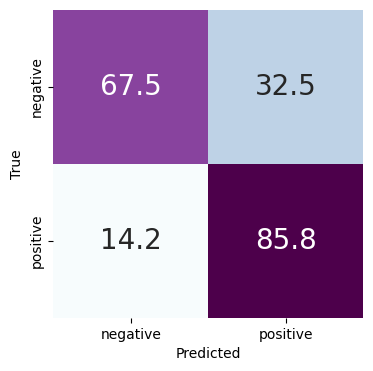

In [16]:
# Compute the confusion matrix and normalize it to get percentages
cm = confusion_matrix(Y_test, y_pred_rf, normalize='true')

# Multiply by 100 to get percentages and round to 1 decimal place
cm_percentage = (cm * 100).round(1)

# Define the class labels
class_labels = ['negative', 'positive']

# Create heatmap
plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='BuPu', cbar=False,
                      xticklabels=class_labels, yticklabels=class_labels,
                      annot_kws={'va':'center', 'size':20})

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('figures/posterhead21/confusion.png', dpi=300)

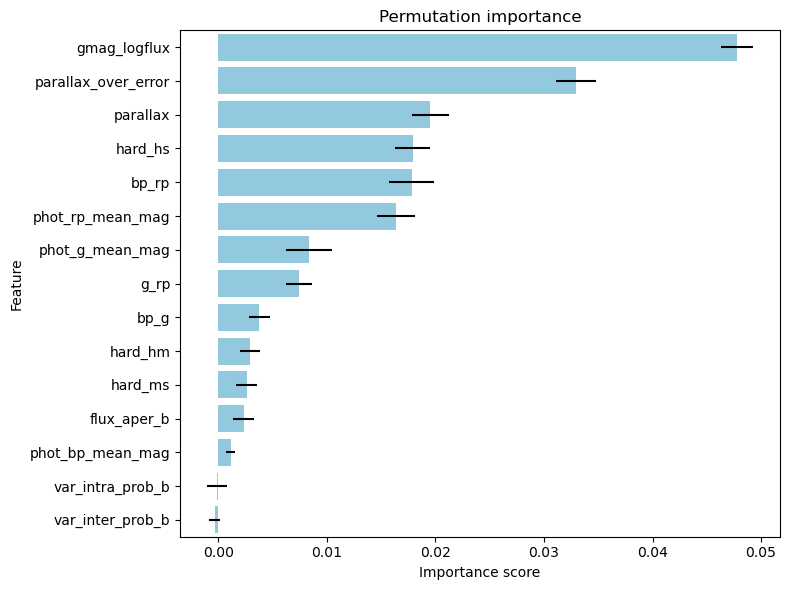

In [17]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()

In [18]:
df_train = df_all.iloc[indices_train]
df_train['prediction'] = clf_rf.predict(X_train)
df_train['actual'] = Y_train
y_train_rf_prob = clf_rf.predict_proba(X_train)[:, 1]

df_test = df_all.iloc[indices_test]
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

dfs = [df_train, df_test]
names = ['Train', 'Test']

features = feature_names

/tmp/ipykernel_103704/2406321621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction'] = clf_rf.predict(X_train)
/tmp/ipykernel_103704/2406321621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['actual'] = Y_train
/tmp/ipykernel_103704/2406321621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

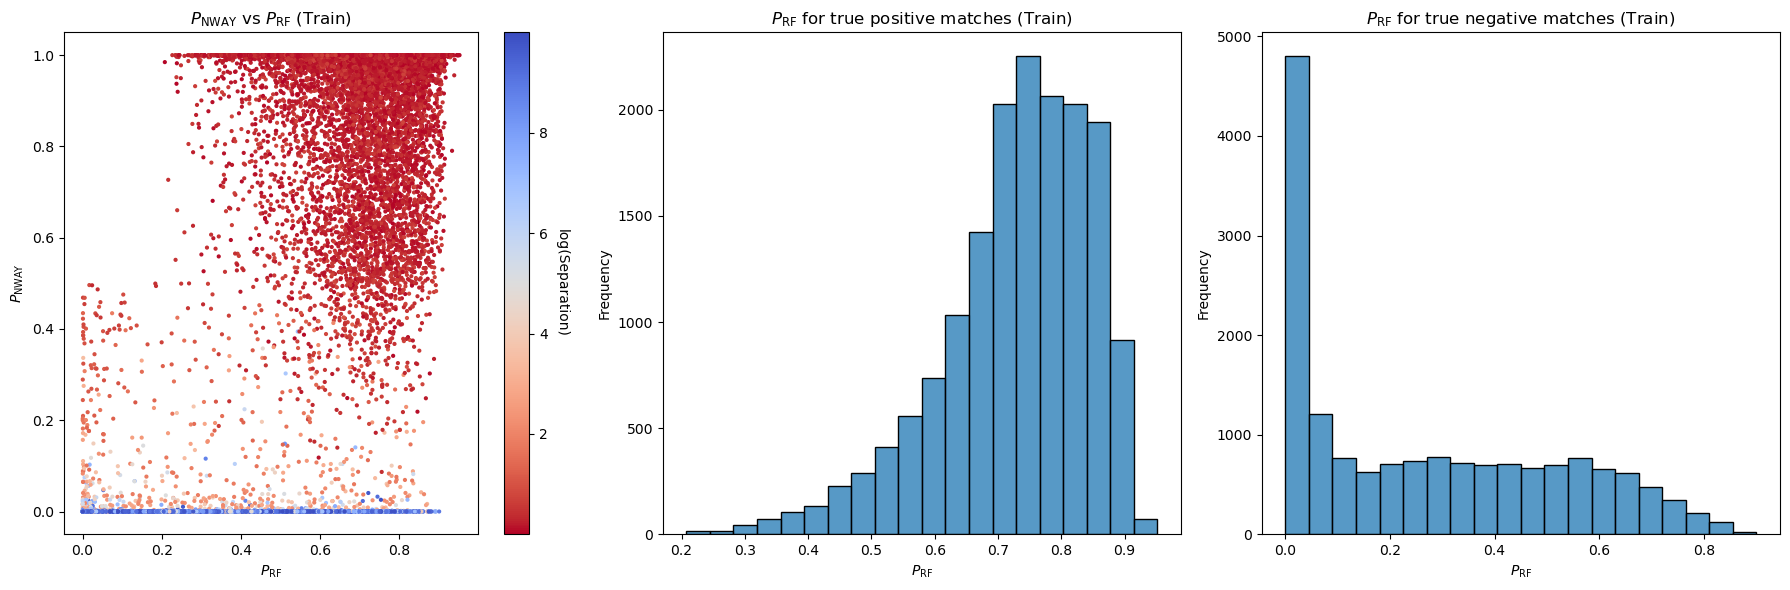

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('figures/posterhead21/histograms_probs.pdf') as pdf:
    # plot for each
    for dataset, pred_prob, title in zip([df_train, df_test], 
                                        [y_train_rf_prob, y_pred_rf_prob], 
                                        ['Train', 'Test']):
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        # scatter
        cmap = 'coolwarm_r'
        #norm = plt.Normalize(dataset['nway_separation'].min(), dataset['nway_separation'].max())
        sc = ax[0].scatter(pred_prob, dataset['p_i'], 
                        c=dataset['nway_separation'], cmap=cmap, s=4)
        cbar = plt.colorbar(sc, ax=ax[0])
        cbar.set_label('log(Separation)', rotation=270, labelpad=15)
        ax[0].set_title(r'$P_{\mathrm{NWAY}}$ vs $P_{\mathrm{RF}}$ (%s)' % title)
        ax[0].set_ylabel(r'$P_{\mathrm{NWAY}}$')
        ax[0].set_xlabel(r'$P_{\mathrm{RF}}$')
        
        # histogram
        sns.histplot(pred_prob[dataset.actual == 1], bins=20, kde=False, ax=ax[1])
        ax[1].set_title(r'$P_{\mathrm{RF}}$ for true positive matches (%s)' % title)
        ax[1].set_xlabel(r'$P_{\mathrm{RF}}$')
        ax[1].set_ylabel('Frequency')
        
        # histogram
        sns.histplot(pred_prob[dataset.actual == 0], bins=20, kde=False, ax=ax[2])
        ax[2].set_title(r'$P_{\mathrm{RF}}$ for true negative matches (%s)' % title)
        ax[2].set_xlabel(r'$P_{\mathrm{RF}}$')
        ax[2].set_ylabel('Frequency')
        
        plt.tight_layout()
        pdf.savefig(fig); 
plt.close();